In [4]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

api = wandb.Api()
ENT = "TomFrederik"
PROJ = "MT-ToyTask-Ours"
# JOB_ID = "9749050" #NOTE <-- change this for new runs
JOB_ID = "9757091" #NOTE <-- change this for new runs
NUM_SEEDS = 5
RED_VOLUME = True

def gen_run_id_list(job_id):
    my_list = []
    for setting_num in range(21):
        for seed_num in range(3):
            my_list.append(f"setting_{setting_num}_seed_{seed_num}_job_{job_id}")
    return my_list

def fetch_last_loss(run_id: str, loss_name: str = "tuning_loss") -> float:
    run = api.run(f"{ENT}/{PROJ}/{run_id}")
    return run.history(keys=[f'Validation/{loss_name}']).iloc[-1][f'Validation/{loss_name}']


def fetch_loss_list_per_setting(job_id, loss_name: str = "tuning_loss"):
    out_dict = dict()
    for setting_num in tqdm(range(21)):
        loss_list = []
        if RED_VOLUME and setting_num not in [7, 10, 12]:
        # if RED_VOLUME and setting_num not in [7, 8, 10, 12]:
            continue
        for seed_num in range(NUM_SEEDS):
            if setting_num == 5 and seed_num == 4:
                print("WARNING: skipping setting 5, seed 4 -> need to run this again due to time limit")
                continue
            run_id = f"setting_{setting_num}_seed_{seed_num}_job_{job_id}"
            loss = fetch_last_loss(run_id, loss_name)
            loss_list.append(loss)
        out_dict[setting_num] = loss_list
    return out_dict

def compute_mean_std_per_setting(loss_dict):
    out_dict = dict()
    for key, val in loss_dict.items():
        mean = np.mean(val)
        std = np.std(val, ddof=1)
        out_dict[key] = (mean, std)
    return out_dict

In [9]:
# run id lists per setting
no_05 = [2, 4, 6]
yes_05 = [0, 1, 3, 5]
no_075 = [9, 11, 13]
# yes_075 = [7, 8, 10, 12]
yes_075 = [7, 10, 12]
no_1 = [16, 18, 20]
yes_1 = [14, 15, 17, 19]

In [6]:
# loss_name = "value_prefix_loss"
loss_name = "tuning_loss"
mean_std_per_setting = compute_mean_std_per_setting(fetch_loss_list_per_setting(JOB_ID, loss_name))

100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


In [7]:
print(mean_std_per_setting)

{7: (1.0171567678451539, 0.24256508449706235), 10: (1.0374948978424072, 0.22179140446954979), 12: (0.9206798076629639, 0.1514047803548902)}


In [10]:
test_only_true_view_075 = [mean_std_per_setting[key] for key in yes_075]
if not RED_VOLUME:
    test_only_true_view_05 = [mean_std_per_setting[key] for key in yes_05]
    test_only_true_view_1 = [mean_std_per_setting[key] for key in yes_1]

    test_only_false_view_05 = [mean_std_per_setting[key] for key in no_05]
    test_only_false_view_075 = [mean_std_per_setting[key] for key in no_075]
    test_only_false_view_1 = [mean_std_per_setting[key] for key in no_1]

In [ ]:
print(test_only_true_view_05)

[(1.6386680126190185, 0.6967550285806802), (1.6260901093482971, 0.675471341779685), (1.585414707660675, 0.6400109239921467), (1.225545957684517, 0.48680964096903556)]


In [11]:
# xticks_yes = np.array([0, 0.1, 0.2, 0.5])
xticks_yes = np.array([0, 0.2, 0.5])
xticks_no = np.array([0.1, 0.2, 0.5])
plot_kwargs = dict(width=0.025, capsize=4)

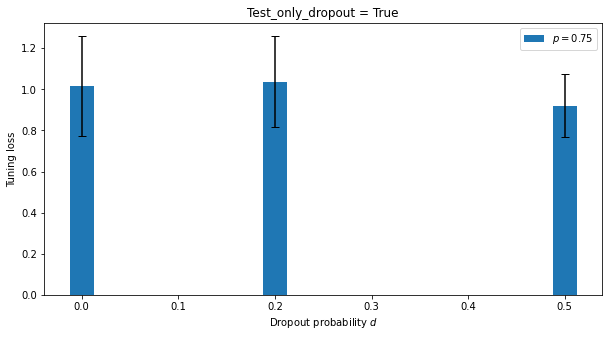

In [12]:
# eval for test_only true
fig, ax = plt.subplots(figsize=(10, 5))
if not RED_VOLUME:
    ax.bar(xticks_yes-0.025, [x[0] for x in test_only_true_view_05], yerr=[x[1] for x in test_only_true_view_05], label=r"$p=0.5$", **plot_kwargs)
    ax.bar(xticks_yes+0.025, [x[0] for x in test_only_true_view_1], yerr=[x[1] for x in test_only_true_view_1], label=r"$p=1$", **plot_kwargs)
ax.bar(xticks_yes, [x[0] for x in test_only_true_view_075], yerr=[x[1] for x in test_only_true_view_075], label=r"$p=0.75$", **plot_kwargs)
plt.title("Test_only_dropout = True")
plt.xlabel(r"Dropout probability $d$")
# plt.yscale("log")
plt.ylabel("Tuning loss")
plt.legend()

In [13]:
# eval for test_only false
if not RED_VOLUME:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(xticks_no-0.025, [x[0] for x in test_only_false_view_05], yerr=[x[1] for x in test_only_false_view_05], label=r"$p=0.5$", **plot_kwargs)
    ax.bar(xticks_no, [x[0] for x in test_only_false_view_075], yerr=[x[1] for x in test_only_false_view_075], label=r"$p=0.75$", **plot_kwargs)
    ax.bar(xticks_no+0.025, [x[0] for x in test_only_false_view_1], yerr=[x[1] for x in test_only_false_view_1], label=r"$p=1$", **plot_kwargs)
    plt.title("Test_only_dropout = False")
    # plt.yscale("log")
    plt.xlabel(r"Dropout probability $d$")
    plt.ylabel("Tuning loss")
    plt.legend()

## Line Plots

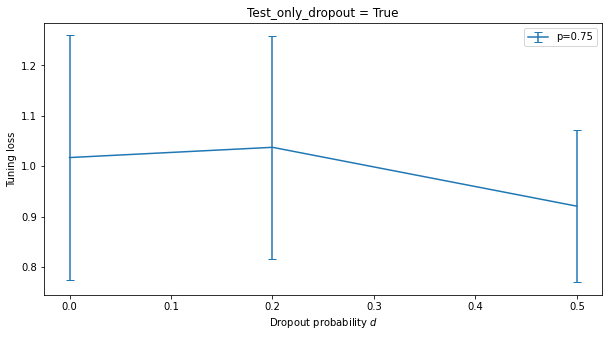

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(xticks_yes, [x[0] for x in test_only_true_view_075], label=r"$p=0.75$")
ax.errorbar(xticks_yes, [x[0] for x in test_only_true_view_075], yerr=[x[1] for x in test_only_true_view_075], label="p=0.75", capsize=plot_kwargs['capsize'])
plt.title("Test_only_dropout = True")
# plt.yscale("log")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()